# Games Deviation Trend Modeling

This notebook models how much the descriptions of games workouts vary over the course of each year's events, using the embedded descriptions.

In [1]:
from os.path import join
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial import distance_matrix

In [2]:
import pymc as pm
import arviz as az
from patsy import dmatrix

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import markplotlib

In [4]:
prodir = join("..", "data", "processed")
plotdir = join("..", "plots", "embedding-modeling")

In [5]:
def savefig(fig, fn):
    fig.savefig(join(plotdir, fn), dpi=250)
    return None

## load data

In [6]:
workouts = pd.read_json(join(prodir, "embeddings", "embeddings.json"), orient="index")
workouts.embedding = workouts.embedding.apply(np.array)
workouts.head()

,year,competitionType,workoutNumber,workoutDescription,workoutName,embedding,x,y,cluster
0,2007,games,1,"For time:\n1,000-meter row\nThen, 5 rounds of:...",Hopper,"[-0.0368132032, -0.053497295800000004, -0.0183...",-0.738916,25.938051,1
1,2007,games,2,Trail run (approximately 5 k)\n,Trail Run,"[-0.034567073000000004, -0.0422704034, -0.0119...",54.330540,3.041909,20
2,2007,games,3,Back squat 1-rep max\nPress 1-rep max\nDeadlif...,CrossFit Total,"[-0.0132969813, -0.0077724895, -0.0206580721, ...",-68.499756,-0.792810,28
3,2008,games,1,21-15-9 reps for time of:\nThrusters (95/65 lb...,Fran,"[-0.0288402978, -0.0277059935, -0.015663057600...",-26.279259,18.278761,2
4,2008,games,2,5 rounds for time of:\n5 Deadlifts (275/185 lb...,Deadlift / Burpee,"[-0.0147087425, -0.0438195169, -0.0073943771, ...",-15.344202,-25.640091,21


In [7]:
comp = "games"
df = workouts[workouts.competitionType == comp].copy()
X = np.stack(df.embedding)
m = X.mean(axis=0)
df["dev"] = [euclidean(m, X[i, :]) for i in range(X.shape[0])]
df["z"] = (df.dev - df.dev.mean()) / df.dev.std()
df["t"] = np.hstack(
    df.groupby("year")
    .apply(lambda x: np.linspace(0, 1, len(x)), include_groups=False)
    .values
)
df.sort_values("t", inplace=True)
df.head()

,year,competitionType,workoutNumber,workoutDescription,workoutName,embedding,x,y,cluster,dev,z,t
0,2007,games,1,"For time:\n1,000-meter row\nThen, 5 rounds of:...",Hopper,"[-0.0368132032, -0.053497295800000004, -0.0183...",-0.738916,25.938051,1,0.612007,-1.124366,0.0
60,2013,games,1,10 rounds for time of:\nSwim 25 yards\n3 Bar m...,The Pool,"[-0.0163451117, -0.041051585200000004, -0.0175...",-3.973442,17.314753,35,0.694930,-0.219242,0.0
77,2014,games,1,For time:\nSwim 250 yards\n50 kettlebell thrus...,The Beach,"[-0.010355271400000001, -0.061843615000000005,...",4.304588,-7.928195,32,0.645546,-0.758274,0.0
24,2011,games,1,"For time:\n210-meter Ocean swim\n1,500-meter S...",Beach,"[-0.0005682947, -0.0704420656, -0.0174894817, ...",35.768059,11.748437,16,0.639742,-0.821628,0.0
95,2015,games,1,For time:\nSwim 500 meters\nPaddle 2 miles\nSw...,Pier Paddle,"[-0.0129153514, -0.0359045379, -0.022343071200...",48.276821,12.799595,29,0.773354,0.636776,0.0


## initial plots

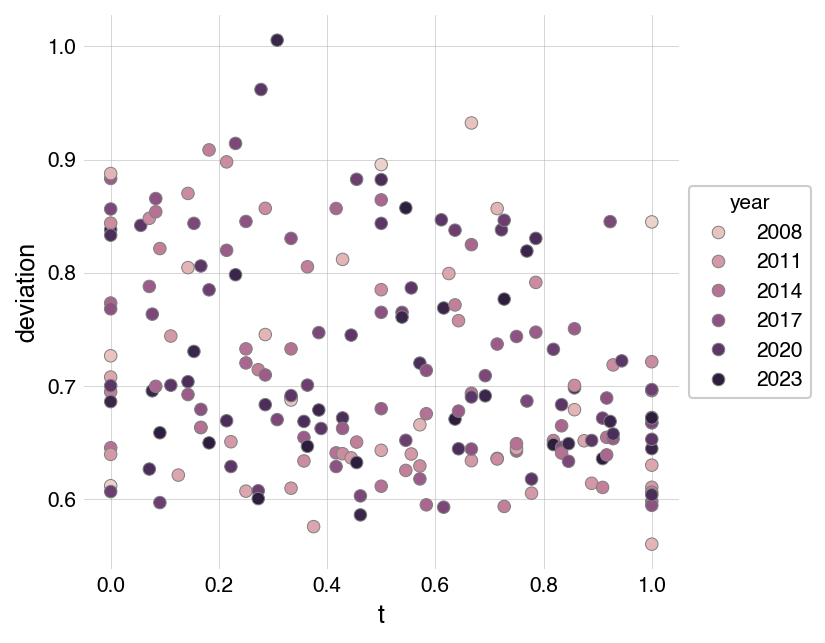

In [8]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="t", y="dev", hue="year", ec="gray", ax=ax)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_ylabel("deviation")
ax.get_legend().set_title("year")
savefig(fig, "t_vs_deviation")

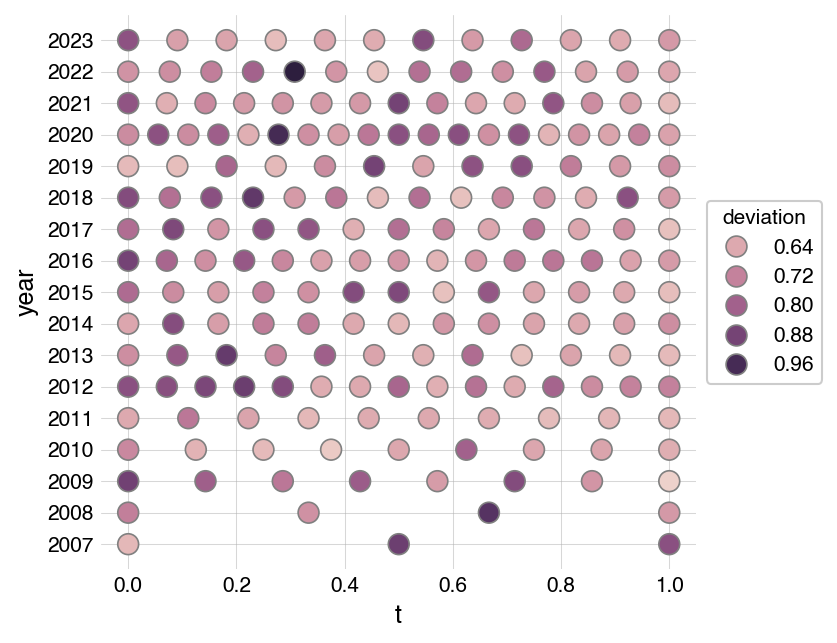

In [9]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="t", y="year", hue="dev", ec="gray", s=100, ax=ax)
ax.set_yticks(np.arange(2007, 2024))
ax.set_yticklabels(np.arange(2007, 2024))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.get_legend().set_title("deviation")
savefig(fig, "t_vs_year")

## modeling

In [10]:
def spline_model(dof, degree, df):

    x = df.t.values
    M = np.asarray(
        dmatrix(f"bs(x, df={dof}, degree={degree}, include_intercept=True) - 1")
    )
    x_dense = np.linspace(0, 1, 250)
    M_dense = np.asarray(
        dmatrix("bs(x_dense, df=dof, degree=degree, include_intercept=True) - 1")
    )
    M.shape

    with pm.Model() as model:
        offset = pm.Normal("offset", mu=-0.5, sigma=0.25)
        mu_weights = pm.Normal("mu_weights", mu=0, sigma=1, shape=M.shape[1])
        sigma_weights = pm.Exponential("sigma_weights", scale=1, shape=M.shape[1])
        alpha = pm.HalfNormal("alpha", sigma=2.5)

        mu = pm.Deterministic("mu", offset + pm.math.dot(M, mu_weights.T))
        sigma = pm.Deterministic("sigma", pm.math.dot(M, sigma_weights.T))

        pm.Deterministic(
            "mean",
            offset
            + pm.math.dot(M_dense, mu_weights.T)
            + pm.math.dot(M_dense, sigma_weights.T)
            * np.sqrt(2 / np.pi)
            * alpha
            / np.sqrt(1 + alpha**2),
        )

        pm.SkewNormal("obs", mu=mu, sigma=sigma, alpha=alpha, observed=df.z.values)

    return model, x, M, x_dense, M_dense

### prior checks

In [11]:
model, x, M, x_dense, M_dense = spline_model(5, 3, df)

In [12]:
with model:
    prior = pm.sample_prior_predictive()

Sampling: [alpha, mu_weights, obs, offset, sigma_weights]


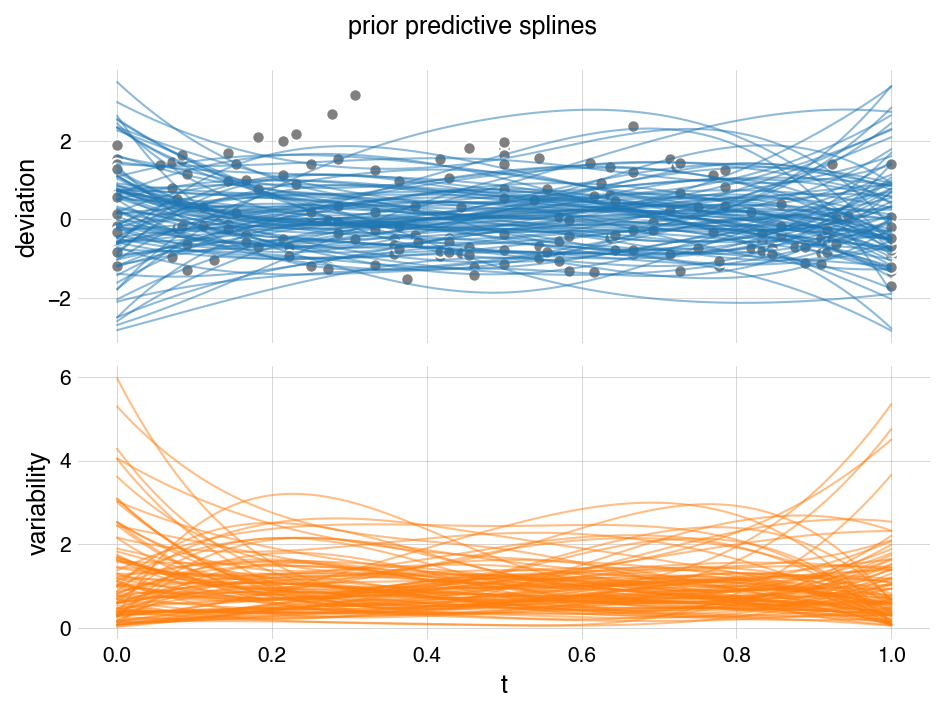

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True)

ax = axs[0]
ax.scatter(df.t.values, df.z.values, color="gray", ec="w")
mu = prior.prior["mean"]
for i in range(100):
    ax.plot(x_dense, mu[0, i, :], color="C0", linewidth=1, alpha=0.5)
ax.set_ylabel("deviation")

ax = axs[1]
w = prior.prior["sigma_weights"]
for i in range(100):
    ax.plot(x_dense, np.dot(M_dense, w[0, i, :]), color="C1", linewidth=1, alpha=0.5)
ax.set_xlabel("t")
ax.set_ylabel("variability")

fig.suptitle("prior predictive splines")
fig.tight_layout()
savefig(fig, "prior_predictive")

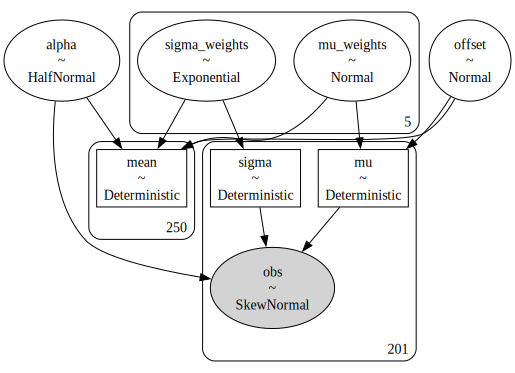

In [14]:
pm.model_to_graphviz(model)

### posterior sampling

In [15]:
with model:
    post = pm.sample(draws=8_000, chains=12, cores=12)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [offset, mu_weights, sigma_weights, alpha]


Sampling 12 chains for 1_000 tune and 8_000 draw iterations (12_000 + 96_000 draws total) took 33 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


<Figure size 960x720 with 0 Axes>

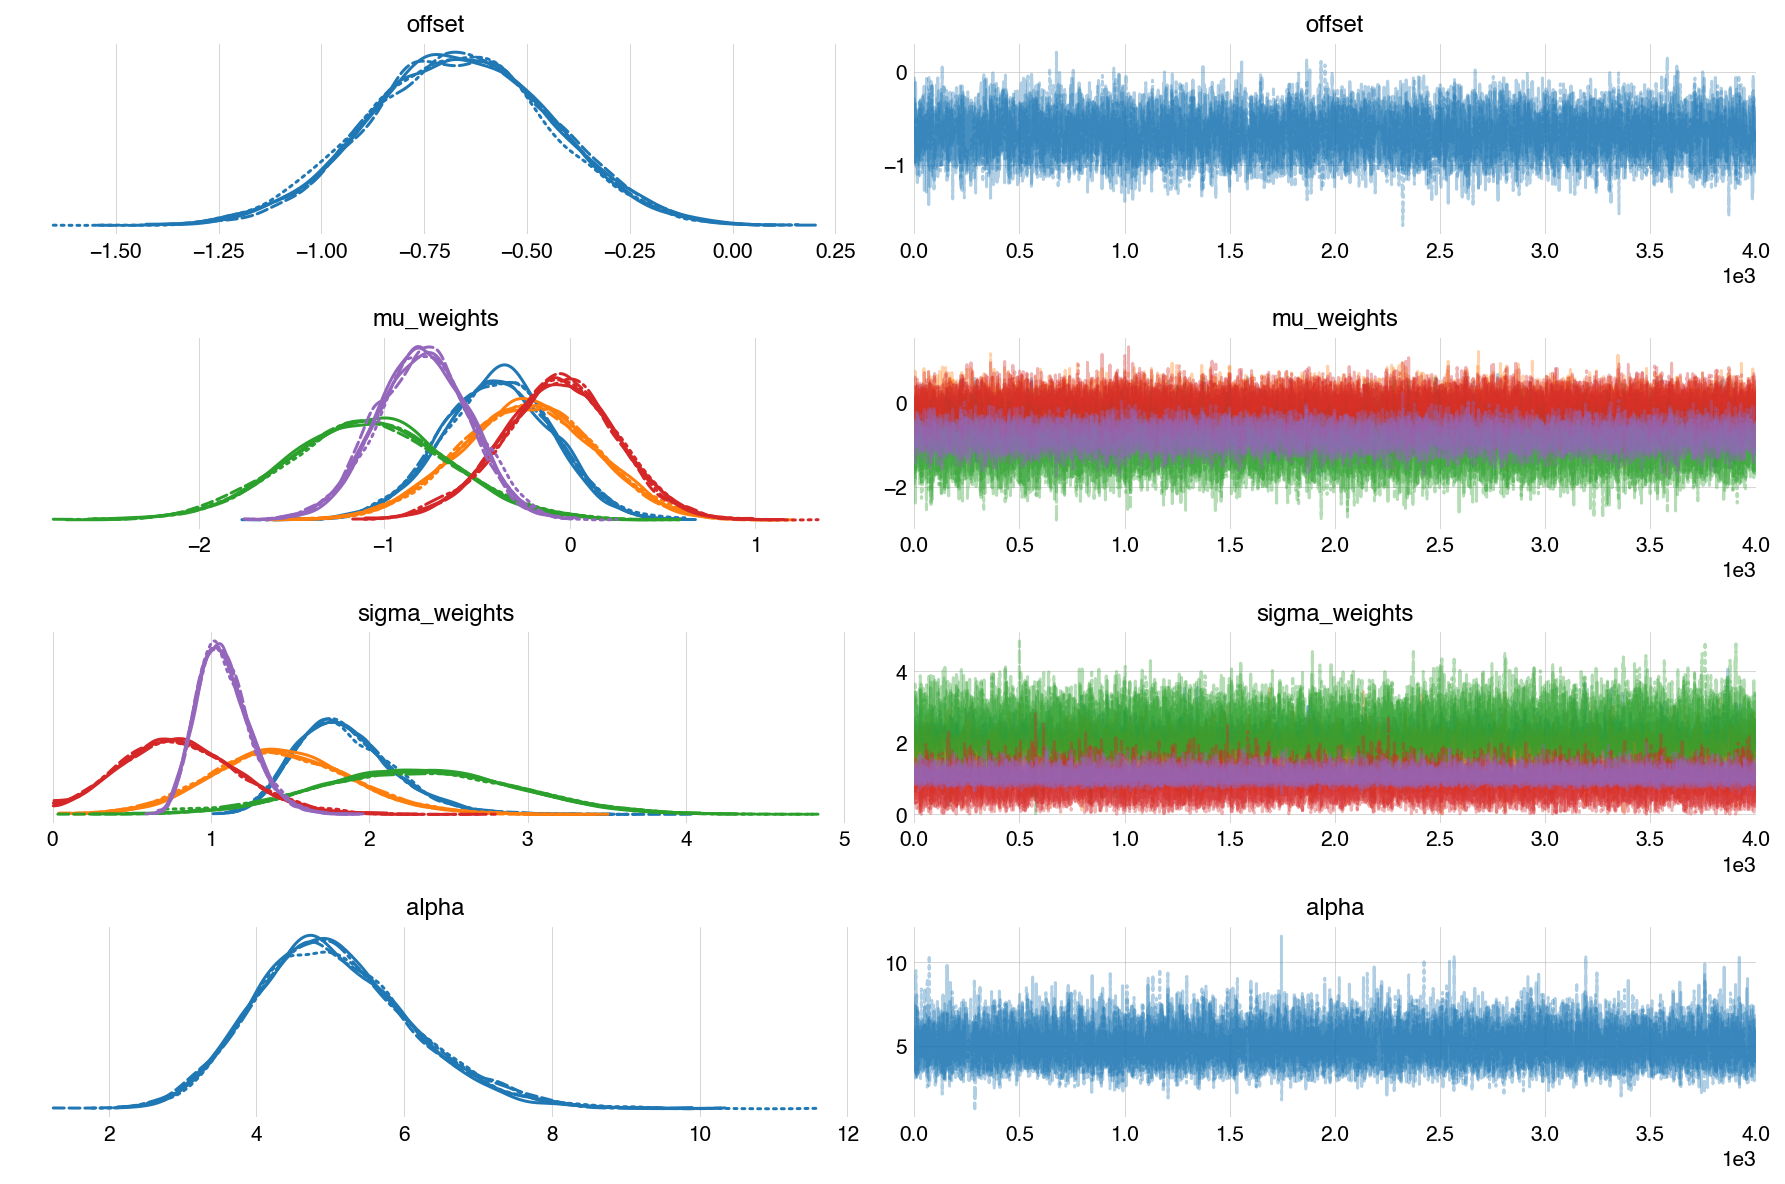

In [16]:
fig = plt.figure()
az.plot_trace(
    post.posterior.sel(chain=slice(0, 4), draw=slice(None, 4_000)),
    var_names=["offset", "mu_weights", "sigma_weights", "alpha"],
)
plt.tight_layout()
savefig(fig, "posterior_trace")

<Figure size 960x720 with 0 Axes>

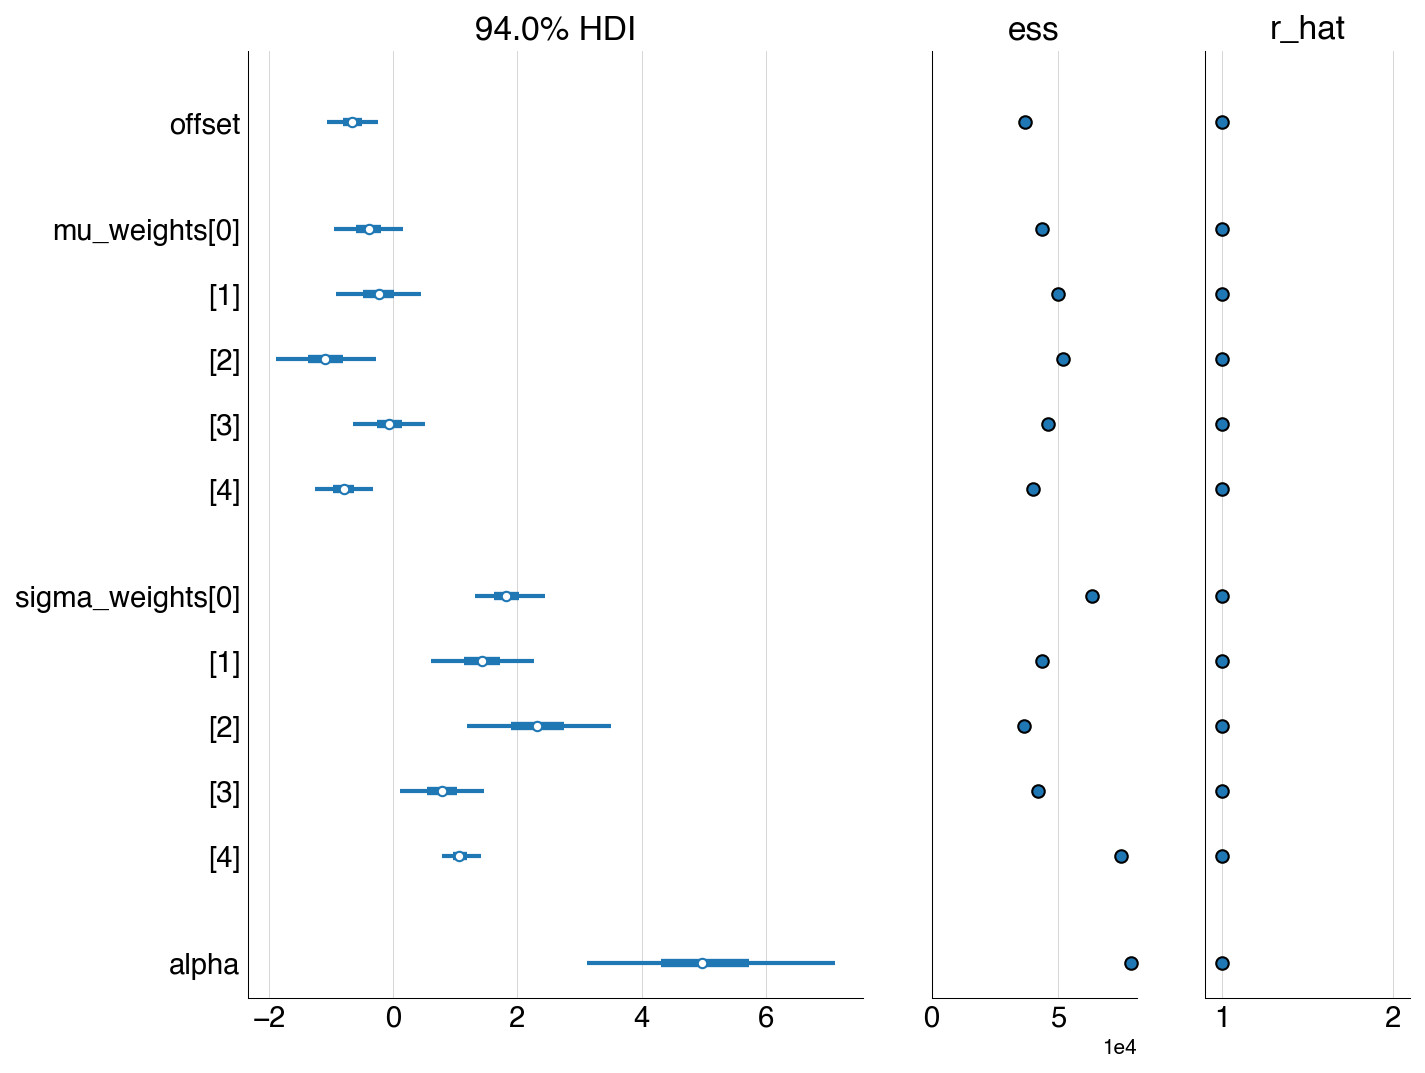

In [17]:
fig = plt.figure()
axs = az.plot_forest(
    post,
    var_names=["offset", "mu_weights", "sigma_weights", "alpha"],
    ess=True,
    r_hat=True,
    combined=True,
)
for ax in axs:
    for spine in ("bottom", "left"):
        ax.spines[spine].set_visible(True)

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/var/folders/qg/0t3dfp7d5d76s_bn3v_kh_640000gn/T/ipykernel_64315/3297650315.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title("model average deviation ($\mu$)")


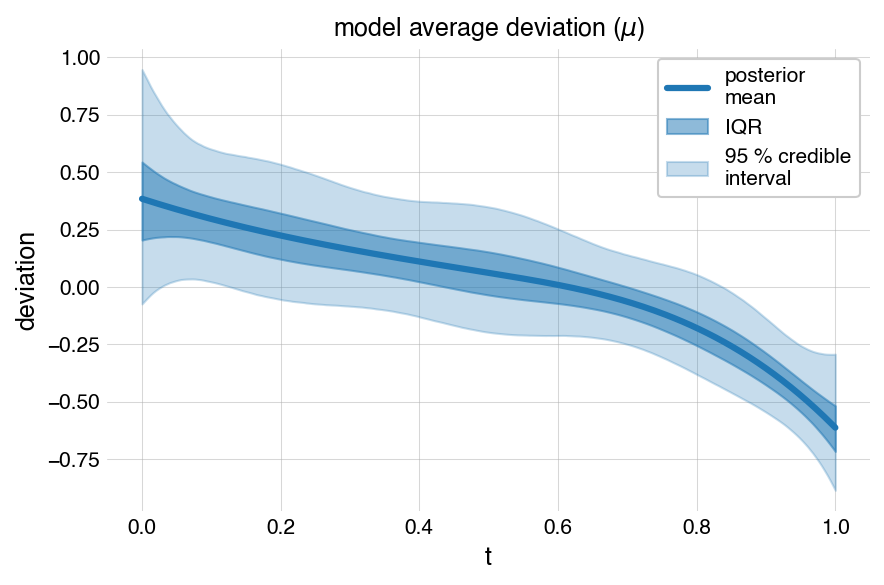

In [26]:
fig, ax = plt.subplots(figsize=(6, 4), sharex=True)
f = post.posterior["mean"]
# ax.scatter(df.t.values, df.z.values, color="gray", ec="w", alpha=0.5, label="data")
ax.plot(x_dense, f.mean(axis=(0, 1)), linewidth=3, label="posterior\nmean")
ax.fill_between(
    x_dense,
    np.quantile(f, 0.25, axis=(0, 1)),
    np.quantile(f, 0.75, axis=(0, 1)),
    alpha=0.5,
    color="C0",
    label="IQR",
)
ax.fill_between(
    x_dense,
    np.quantile(f, 0.025, axis=(0, 1)),
    np.quantile(f, 0.975, axis=(0, 1)),
    alpha=0.25,
    color="C0",
    label="95 % credible\ninterval",
)
ax.legend()
ax.set_title("model average deviation ($\mu$)")
ax.set_ylabel("deviation")
ax.set_xlabel("t")
fig.tight_layout()

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
/var/folders/qg/0t3dfp7d5d76s_bn3v_kh_640000gn/T/ipykernel_64315/2630604119.py:23: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title("model average deviation ($\mu$)")
/var/folders/qg/0t3dfp7d5d76s_bn3v_kh_640000gn/T/ipykernel_64315/2630604119.py:47: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title("model deviation variability ($\sigma$)")


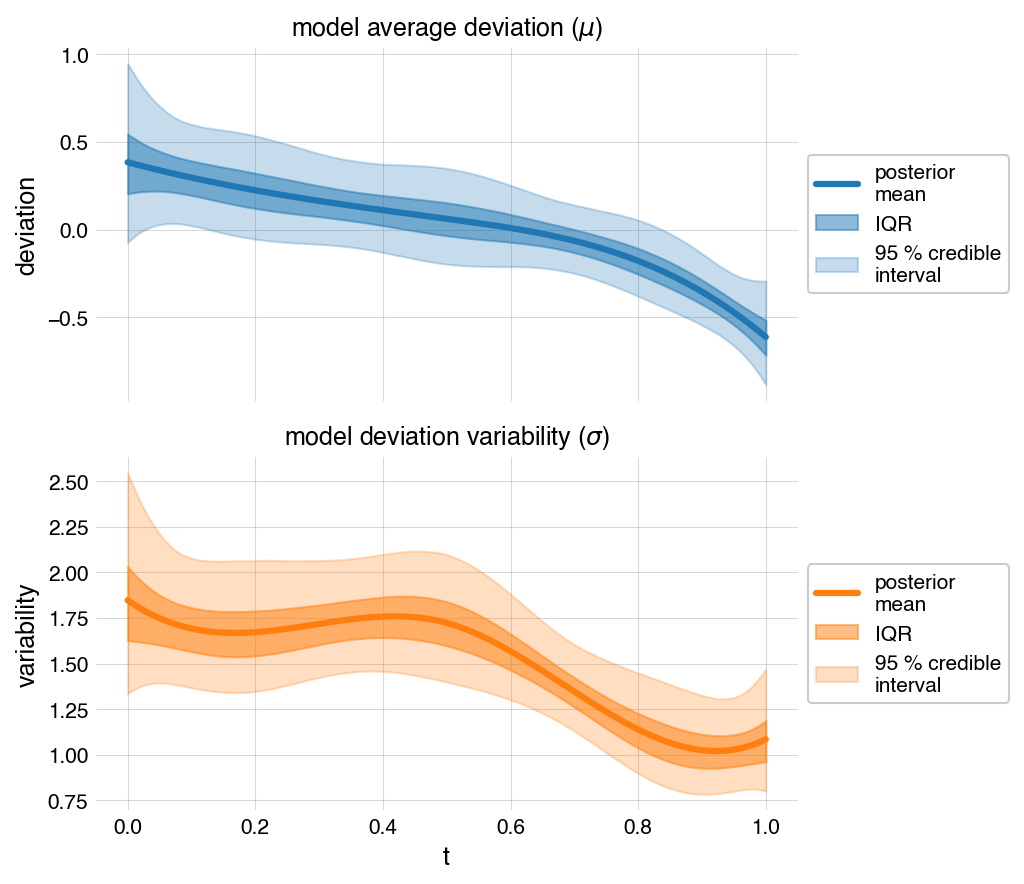

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax = axs[0]
f = post.posterior["mean"]
# ax.scatter(df.t.values, df.z.values, color="gray", ec="w", alpha=0.5, label="data")
ax.plot(x_dense, f.mean(axis=(0, 1)), linewidth=3, label="posterior\nmean")
ax.fill_between(
    x_dense,
    np.quantile(f, 0.25, axis=(0, 1)),
    np.quantile(f, 0.75, axis=(0, 1)),
    alpha=0.5,
    color="C0",
    label="IQR",
)
ax.fill_between(
    x_dense,
    np.quantile(f, 0.025, axis=(0, 1)),
    np.quantile(f, 0.975, axis=(0, 1)),
    alpha=0.25,
    color="C0",
    label="95 % credible\ninterval",
)
ax.legend()
ax.set_title("model average deviation ($\mu$)")
ax.set_ylabel("deviation")

ax = axs[1]
w = post.posterior["sigma_weights"]
f = np.tensordot(M_dense, w.values, axes=([1], [2]))
ax.plot(x_dense, f.mean(axis=(1, 2)), linewidth=3, color="C1", label="posterior\nmean")
ax.fill_between(
    x_dense,
    np.quantile(f, 0.25, axis=(1, 2)),
    np.quantile(f, 0.75, axis=(1, 2)),
    color="C1",
    alpha=0.5,
    label="IQR",
)
ax.fill_between(
    x_dense,
    np.quantile(f, 0.025, axis=(1, 2)),
    np.quantile(f, 0.975, axis=(1, 2)),
    color="C1",
    alpha=0.25,
    label="95 % credible\ninterval",
)
ax.legend()
ax.set_title("model deviation variability ($\sigma$)")
ax.set_ylabel("variability")

for ax in axs:
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_axisbelow(True)
axs[1].set_xlabel("t")

fig.tight_layout()
savefig(fig, "posterior_splines")

### posterior predictive

In [20]:
with model:
    ppc = pm.sample_posterior_predictive(post, progressbar=False)

Sampling: [obs]


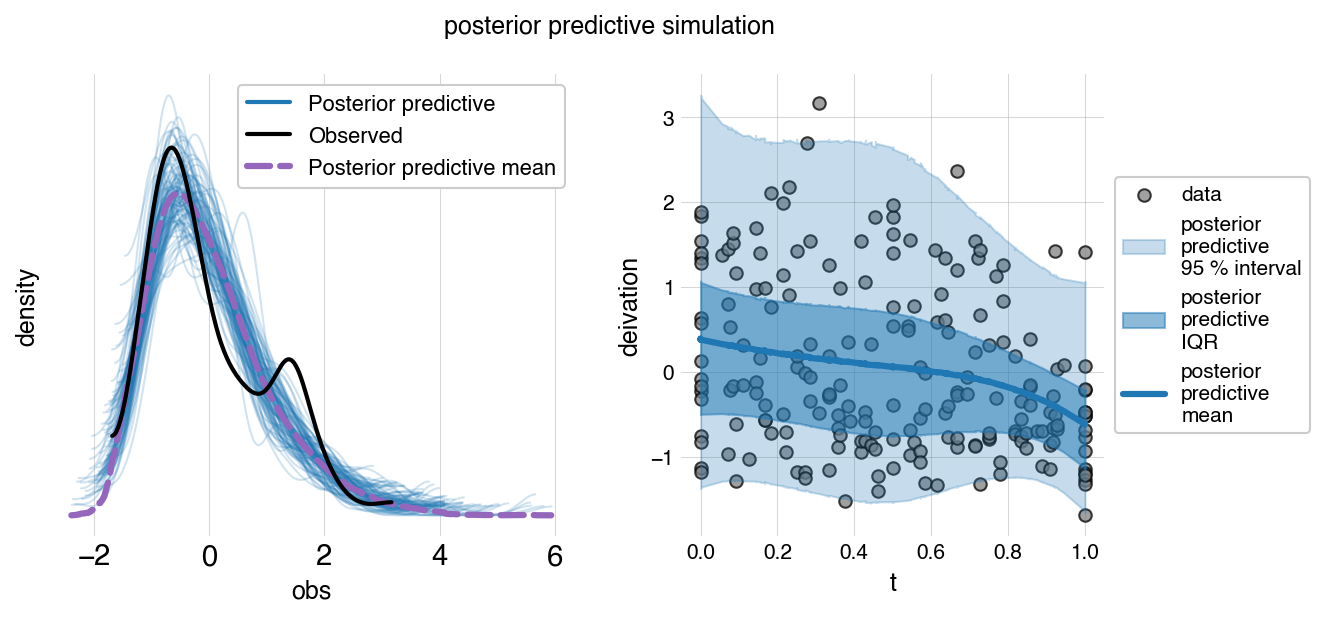

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

az.plot_ppc(ppc, num_pp_samples=100, colors=["C0", "black", "C4"], ax=axs[0])
axs[0].set_ylabel("density")

ax = axs[1]
p = ppc.posterior_predictive["obs"]
ax.scatter(df.t.values, df.z.values, color="gray", ec="k", alpha=0.75, label="data")
ax.fill_between(
    x,
    p.quantile(0.025, dim=("chain", "draw")),
    p.quantile(0.975, dim=("chain", "draw")),
    color="C0",
    alpha=0.25,
    label="posterior\npredictive\n95 % interval",
)
ax.fill_between(
    x,
    p.quantile(0.25, dim=("chain", "draw")),
    p.quantile(0.75, dim=("chain", "draw")),
    color="C0",
    alpha=0.5,
    label="posterior\npredictive\nIQR",
)
ax.plot(
    x, p.mean(dim=("chain", "draw")), linewidth=3, label="posterior\npredictive\nmean"
)
ax.legend()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("t")
ax.set_ylabel("deivation")

fig.suptitle("posterior predictive simulation")
savefig(fig, "posterior_predictive")

# model comparison

In [22]:
models = {}
dof = (4, 5, 6, 7, 8)
for i in range(len(dof)):
    model, x, M, x_dense, M_dense = spline_model(dof[i], 3, df)
    with model:
        trace = pm.sample(draws=2_000, chains=16, cores=16, progressbar=False)
        pm.compute_log_likelihood(trace, progressbar=False)
    models[f"{dof[i]} DoF"] = trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [offset, mu_weights, sigma_weights, alpha]
Sampling 16 chains for 1_000 tune and 2_000 draw iterations (16_000 + 32_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [offset, mu_weights, sigma_weights, alpha]
Sampling 16 chains for 1_000 tune and 2_000 draw iterations (16_000 + 32_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [offset, mu_weights, sigma_weights, alpha]
Sampling 16 chains for 1_000 tune and 2_000 draw iterations (16_000 + 32_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [offset, mu_weights, sigma_weights, alpha]

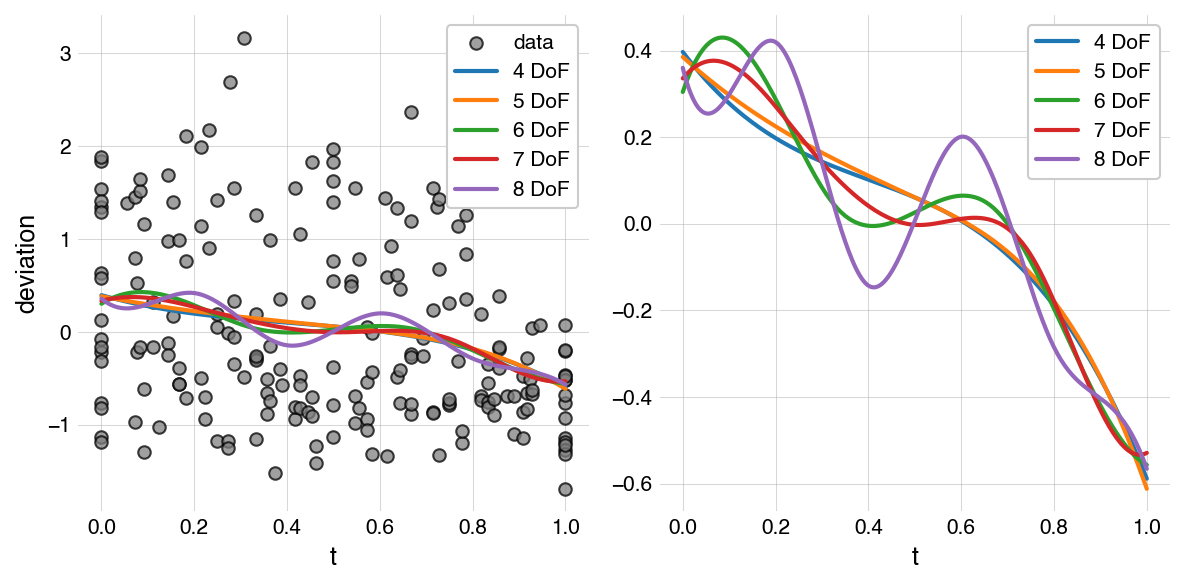

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
axs[0].scatter(df.t.values, df.z.values, color="gray", ec="k", alpha=0.75, label="data")
for ax in axs:
    for i in range(len(dof)):
        k = f"{dof[i]} DoF"
        model = models[k]
        ax.plot(x_dense, model.posterior["mean"].mean(axis=(0, 1)), label=k)
    ax.legend()
    ax.set_xlabel("t")
axs[0].set_ylabel("deviation")
fig.tight_layout()
savefig(fig, "spline_comparison")

In [24]:
comparison = az.compare(models, ic="loo")
comparison

/Users/markbaum/Library/Caches/pypoetry/virtualenvs/xft-AIzqpCa0-py3.12/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/markbaum/Library/Caches/pypoetry/virtualenvs/xft-AIzqpCa0-py3.12/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influenti

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
5 DoF,0,-260.044798,9.200853,0.000000,4.682526e-15,10.446350,0.000000,True,log
6 DoF,1,-260.147996,10.610718,0.103199,5.847614e-01,10.735838,1.735612,False,log
4 DoF,2,-260.466796,7.885305,0.421999,4.152386e-01,10.367481,1.420724,True,log
7 DoF,3,-262.353576,12.575049,2.308778,3.604427e-15,10.907477,2.431705,False,log
8 DoF,4,-263.845225,14.512562,3.800428,0.000000e+00,11.045358,2.754013,True,log


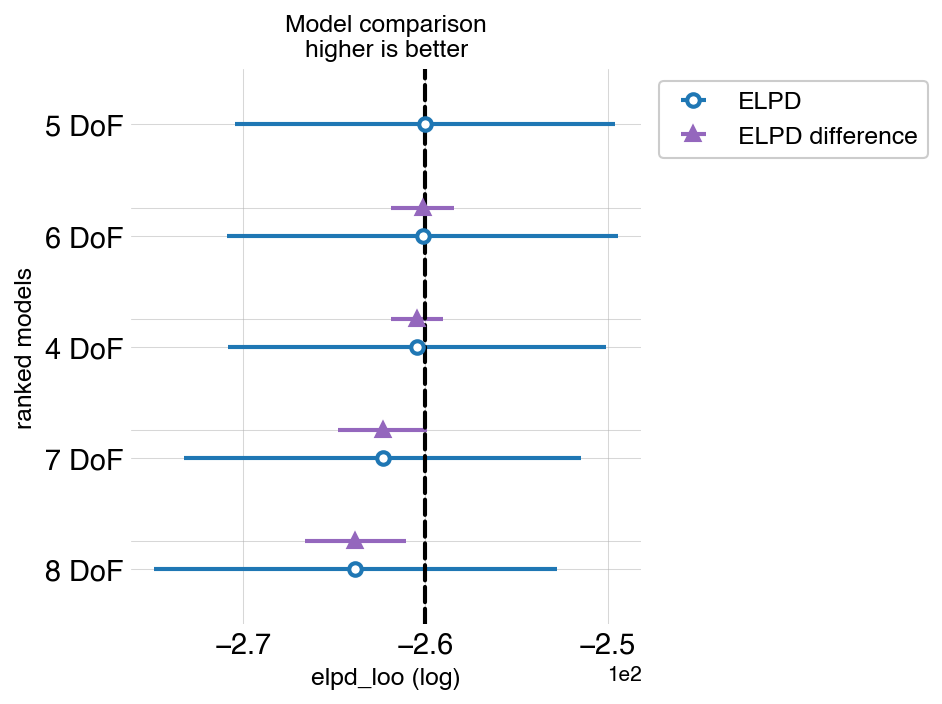

In [25]:
fig, ax = plt.subplots()
az.plot_compare(
    comparison,
    plot_kwargs=dict(color_ic="C0", color_dse="C4", color_ls_min_ic="black"),
    ax=ax,
)
fig.tight_layout()
savefig(fig, "epld_loo")